# Prerequisite

## Download nltk
This work makes havy use of the nltk-framework, the download can be startet with: '#nltk.download()'

In [13]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Checking for GPU

*If you dont have a GPU in your maschine you can ignore these section*

For better performece we recomend using your GPU, if none is detectet consider adding it to your python-enviroment.

In [14]:
import tensorflow as tf

print("There is", len(tf.config.experimental.list_physical_devices('GPU')), "detected GPU")

There is 1 detected GPU


# Loading the Data
We load the required data into to a pandas dataframes and join them by a common field.

for convinient use we transform all identifyers to lower case

In [15]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

There are 227513 datasets loaded


# Remove unneedet data

we removed all samples which arnt english or are duplicates

In [16]:
import pandas as pd

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(['sname','slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom'], axis=1)

# General preprocessing

for further procssesing the lyrics get tokenized, lemmatized and cleand

In [17]:
import pandas as pd

transformed_df = filterd_df
transformed_df['lyric'] = transformed_df['lyric'].str.lower()

In [18]:
transformed_df = transformed_df.sample(frac=0.01)

## Tokenize

In [19]:
import nltk

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda lyric: nltk.sent_tokenize(lyric,language='english')) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda lyric: [nltk.word_tokenize(sentence, language='english') for sentence in lyric]) 

## Lemmatiz

now we lemmatize our tokens, this may take a wile

In [20]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

we remove any artefacts which surviced lematisation like empty words, single letter words and all non alphabetic characters 

In [21]:
import re

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 

## Remove to long lyrics (Optional)

checken ob lieder die länger wie 1000 oder 1500 wirklich save sind, am besten erstmal händisch nachschauen

In [22]:
#todo

## Save to disk

In [11]:
transformed_df.to_csv (r'./export_dataframe2.csv', index = False, header=True)
transformed_df.head()

,lyric,artist,genre
0,"[[could, feel, at, the, time], [there, be, no,...",10000 Maniacs,Rock
2,"[[take, me, now, baby, here, as, be], [hold, m...",10000 Maniacs,Rock
4,"[[these, be], [these, be, day, you, ll, rememb...",10000 Maniacs,Rock
6,"[[lie, to, say, my, mountain, have, coal, vein...",10000 Maniacs,Rock
8,"[[trudge, slowly, over, wet, sand], [back, to,...",10000 Maniacs,Rock


## Load form disk

In [55]:
import pandas as pd

transformed_df = pd.read_csv(r'./export_dataframe.csv', converters={'lyric': eval})
transformed_df.head()

,lyric,artist,genre
0,"[[could, feel, at, the, time], [there, be, no,...",10000 Maniacs,Rock
1,"[[take, me, now, baby, here, as, be], [hold, m...",10000 Maniacs,Rock
2,"[[these, be], [these, be, day, you, ll, rememb...",10000 Maniacs,Rock
3,"[[lie, to, say, my, mountain, have, coal, vein...",10000 Maniacs,Rock
4,"[[trudge, slowly, over, wet, sand], [back, to,...",10000 Maniacs,Rock


In [1]:
from helper import flatten
import pandas as pd
import pickle

restored_df = pd.read_csv(r'./export_dataframe.csv', converters={'lyric': eval})

def get_fresh_copy(frac=1):
    copy_df = pickle.loads(pickle.dumps(restored_df.sample(frac=frac, random_state=1)))
    return copy_df

def get_fresh_flatted_copy(frac=1):
    copy_df = get_fresh_copy(frac)
    copy_df['lyric'] = copy_df['lyric'].transform(lambda x: flatten(x))
    return copy_df
    

# Look at the data

## GenreDistribution

first we will look at the distribution of generes in our dataset

<AxesSubplot:xlabel='genre', ylabel='count'>

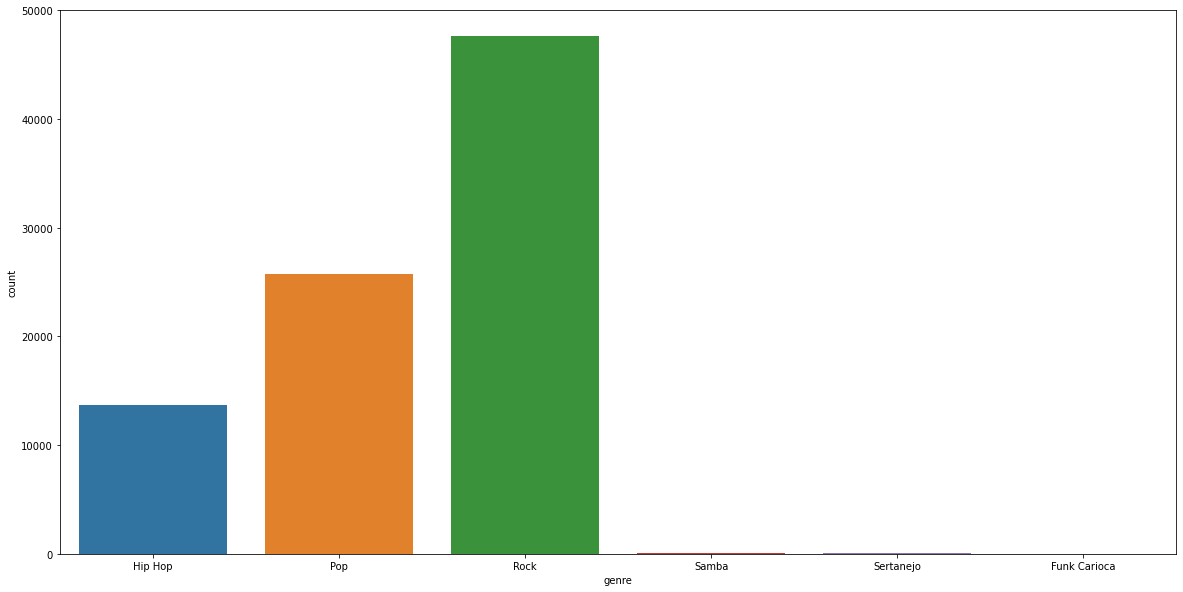

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.countplot(data=get_fresh_copy())

## FreqencyDistribution

freqency distribution of the most common words in our dataset

to see if removing stopwords is a good idea we have a look ate the destribuition of stopwords over the difertent genres

<AxesSubplot:xlabel='words'>

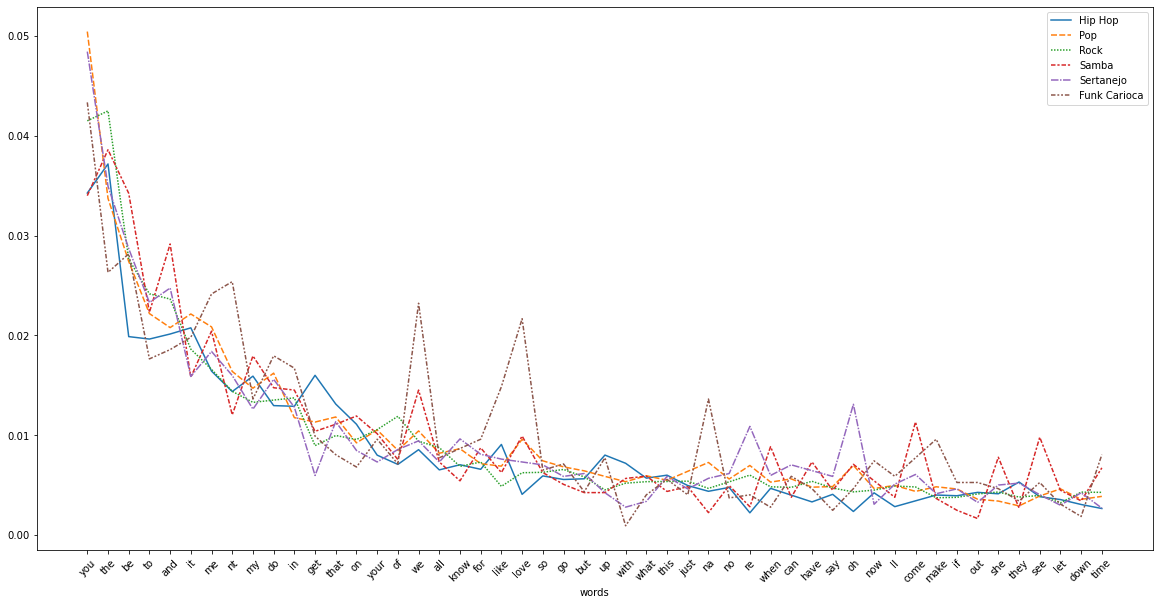

In [19]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
        
flatted_df = get_fresh_flatted_copy(1)
genres = flatted_df.genre.unique()

df_container = {}
fd_container = {}

total_word_count = {}

merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(flatted_df['lyric'])).items(), columns=['words', 'frequency'])
merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

#in viele kleine loops zerhacken und erklären was passiert
#und vielleicht noch den duchschnitt hinzufügen, allso nicht nach genre gefilterd
for genre in genres:
    df_container[genre] = flatted_df[flatted_df.genre.eq(genre)]
    fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
    total_word_count[genre] = sum(fd_container[genre].values())
    fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
    fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
    merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    
merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
merged_fd_df = merged_fd_df.set_index('words')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)    
sns.lineplot(data=merged_fd_df.head(50))

## Lyricslength Distribution by genre(word)

we look if some generes as more likly to have shorter or longer lyrics

In [3]:
def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

<AxesSubplot:xlabel='length', ylabel='count'>

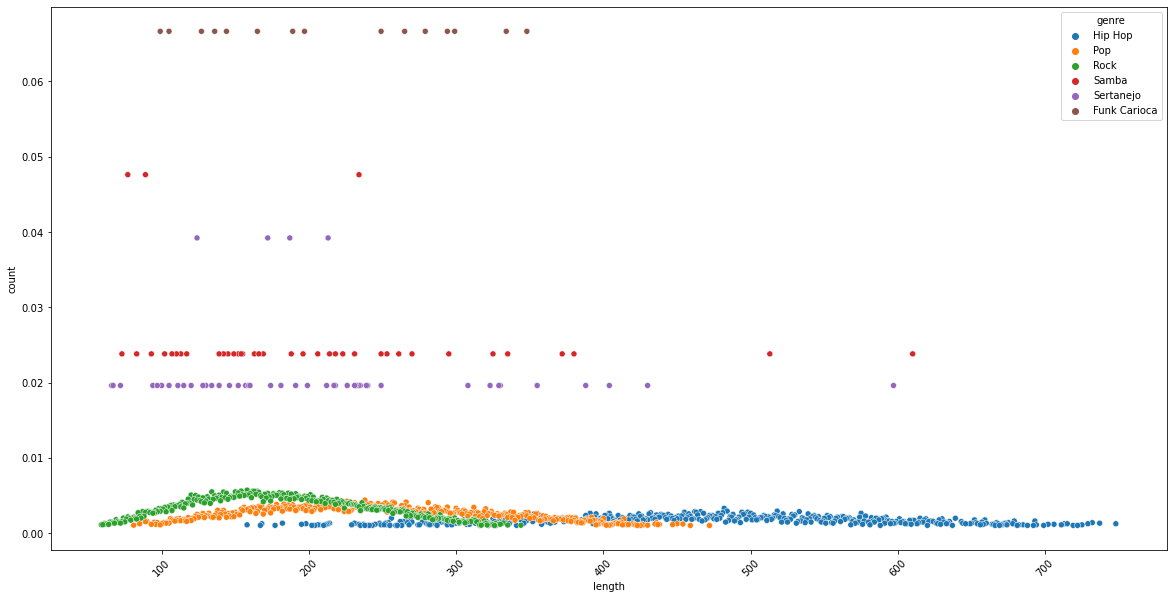

In [4]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(vers)

we look if some generes as more likly to have shorter or longer lyrics

<AxesSubplot:xlabel='length', ylabel='count'>

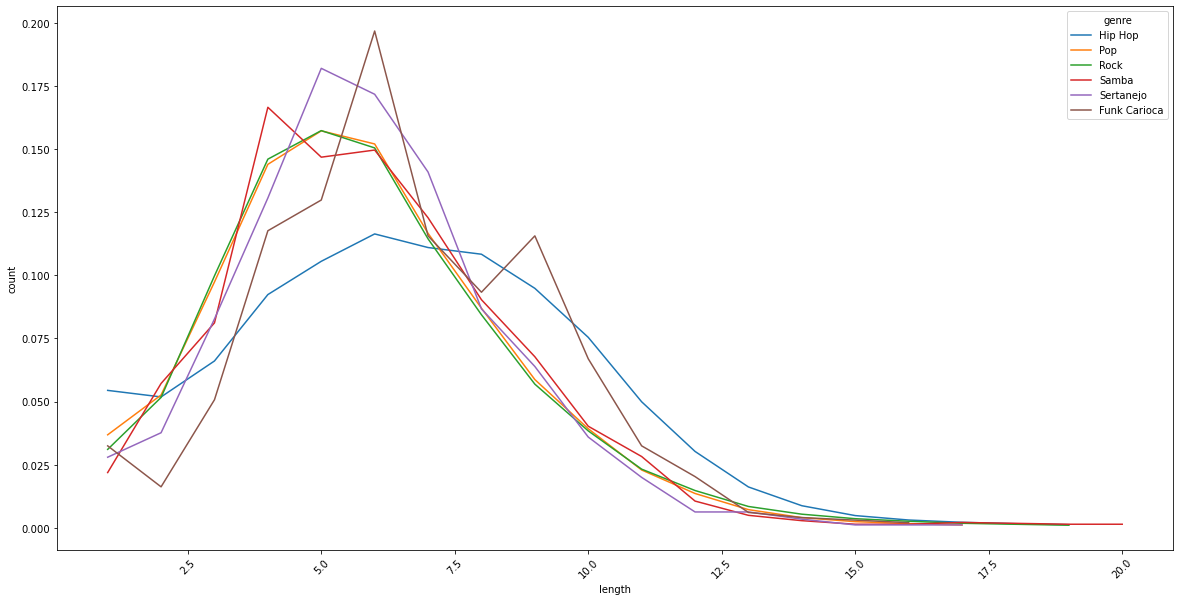

In [5]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(lyric)

we look if some generes as more likly to have shorter or longer lyrics

<AxesSubplot:xlabel='length', ylabel='count'>

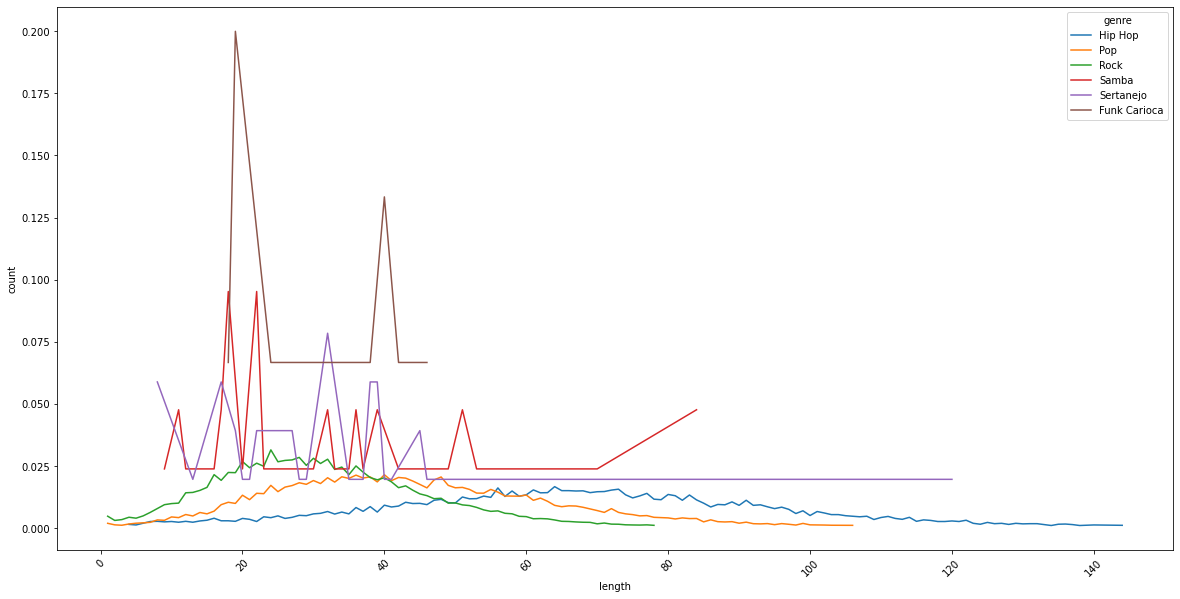

In [6]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

# Learning

In [42]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import keras

#preprocessed_df = get_fresh_flatted_copy()

x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
tokenizer = Tokenizer(num_words=10000)

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

num_classes =  len(transformed_df['genre'].unique())
tokenizer.fit_on_texts(x_train)

print(num_classes)

x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation


model = Sequential()
model.add(Dense(4096, input_shape=(10000, ), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 1

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
#plot_model_feedforward(model, train_seq_x, test_seq_x, trainGenres, testGenres, e_count=5)


6
545/545 [==============================] - 1s 3ms/step - loss: 0.6820 - accuracy: 0.6968


In [40]:
import pandas as pd
preprocessed_df = get_fresh_flatted_copy()

x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
tokenizer = Tokenizer(num_words=10000)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

num_classes =  len(preprocessed_df['genre'].unique())
tokenizer.fit_on_texts(x_train)

print(num_classes)

x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)




from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(4096, input_shape=(10000, ), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 10

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
#plot_model_feedforward(model, train_seq_x, test_seq_x, trainGenres, testGenres, e_count=5)


KeyboardInterrupt: 

In [ ]:


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(4096, input_shape=(10000, ), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
#plot_model_feedforward(model, train_seq_x, test_seq_x, trainGenres, testGenres, e_count=5)

Epoch 1/100
1961/1961 [==============================] - 25s 13ms/step - loss: 0.7549 - accuracy: 0.6683 - val_loss: 0.6710 - val_accuracy: 0.7117
Epoch 2/100
1961/1961 [==============================] - 24s 12ms/step - loss: 0.7002 - accuracy: 0.6898 - val_loss: 0.7047 - val_accuracy: 0.6644
Epoch 3/100
1961/1961 [==============================] - 25s 13ms/step - loss: 0.7004 - accuracy: 0.6843 - val_loss: 0.7002 - val_accuracy: 0.6816
Epoch 4/100
1961/1961 [==============================] - 28s 14ms/step - loss: 0.7217 - accuracy: 0.6795 - val_loss: 0.6854 - val_accuracy: 0.7041
Epoch 5/100
1961/1961 [==============================] - 23s 12ms/step - loss: 0.6995 - accuracy: 0.6926 - val_loss: 0.6949 - val_accuracy: 0.6981
Epoch 6/100
1961/1961 [==============================] - 25s 13ms/step - loss: 0.7247 - accuracy: 0.6806 - val_loss: 0.6920 - val_accuracy: 0.6992
Epoch 7/100
1961/1961 [==============================] - 26s 13ms/step - loss: 0.7120 - accuracy: 0.6865 - val_loss: 0